# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** PIs via XGBoost Random Forest with Quantile Loss Function on Boston Housing dataset

</font>
</div>

# Some theoretical recalls

<div class="alert alert-block alert-info">
<font color=black><br>

- A **CONFIDENCE** interval quantifies the uncertainty on an estimated population variable, such as the mean or 
standard deviation. It can be used to quantify the uncertainty of the estimated skill of a model.
- A **PREDICTION** interval quantifies the uncertainty on a single observation estimated from the population. It
can be used to quantify the uncertainty of a single forecast. 
- **Quantile:** These are points (essentially scalar values) in your data below which a certain proportion of your data fall. Consider a normal distribution with a mean of 0. The 0.5 quantile, or 50th percentile, is 0. Half the data lie below 0. That’s the peak of the hump in the curve. The 0.95 quantile, or 95th percentile, is about 1.64.  

<br></font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd
from math import e
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_pinball_loss
from statistics import stdev
from matplotlib import rcParams
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, ensemble
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor, XGBRFRegressor
from pprint import pprint
rcParams['figure.figsize'] = 25, 8
rcParams['font.size'] = 25

# Helper functions

<div class="alert alert-block alert-info">
<font color=black><br>

- **report** allows you to nicely see the result of the grid search output
- **log_cosh_quantile** implement two version of the quantile: smooth and hard. Use the smooth version as the hard is not differentiable at x = 0

<br></font>
</div>

In [2]:
def report(results, n_top=1):
    """
    Report the first n_top CV results.
    """
    for i in range(1, n_top + 1):
        print(i)
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print(candidate)
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.9f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))

    return np.flatnonzero(results['rank_test_score'] == 1)[0]

In [3]:
# hard or smooth
whichOne = "smooth"
# https://gist.github.com/Nikolay-Lysenko/06769d701c1d9c9acb9a66f2f9d7a6c7


def log_cosh_quantile(alpha):
    """
    LogCosh quantile is nothing more than a smooth quantile loss function.
    This funciotion is C^oo so C1 and C2 which is all we need.
    """
    def _log_cosh_quantile(y_true, y_pred):
        err = (y_pred - y_true)
        err = np.where(err < 0, alpha * err, (1 - alpha) * err)

        if whichOne == "smooth":
            grad = np.tanh(err)
            hess = 1 / np.cosh(err)**2
        if whichOne == "hard":
            grad = np.where(err < 0, alpha, (1 - alpha))
            hess = np.ones_like(err)

        return grad, hess

    return _log_cosh_quantile

# Dataset

<div class="alert alert-block alert-info">
<font color=black><br>

- Let’s look at the well-known **Boston housing** dataset and try to create prediction intervals
- We’ll use 400 samples for training, leaving 106 samples for test. 

<br></font>
</div>

In [4]:
boston = load_boston()
x_df = pd.DataFrame(boston.data, columns = boston.feature_names)
x_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [5]:
y_df = pd.DataFrame(boston.target, columns = ['Target'])
y_df.describe()

,Target
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, 
                                                    test_size=.2,
                                                    shuffle=True, 
                                                    random_state=7)

In [7]:
# This is essentially the validation set
x_train2, x_test2, y_train2, y_test2 = \
train_test_split(X_train, y_train, test_size=.2, random_state=7, shuffle=True)
print(len(x_train2))
print(len(X_train))

323
404


In [8]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 357 to 26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  102 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


# Modelling + no tuning

<div class="alert alert-block alert-info">
<font color=black><br>

- We'll fit 3 models:
    - One for the **lower prediction**
    - One for the **upper prediction**
    - One for the **mid prediction** which predicts the mean. This what is done all the time.
      
- **IMPORTANT**: when we change the loss to quantile and choose alpha (the quantile), we’re able to get predictions 
corresponding to percentiles. If we use lower and upper quantiles, we can produce an estimated range which is exactly 
what we want. 
- **CL** stands for confidence level which is neither CI or PI.

<br></font>
</div>

In [9]:
# Confidence Level
CL = 0.90
alphaUpper = CL + (1 - CL)/2
alphaLower= (1 - CL)/2
print(alphaUpper*100, alphaLower*100)

95.0 4.999999999999999


<div class="alert alert-block alert-info">
<font color=black><br>

- Reference on how to create a custom-made **evaluation_metric** in XGBoost: https://coderzcolumn.com/tutorials/machine-learning/xgboost-an-in-depth-guide-python
- Reference on how the **pin ball loss fnction** works in sklearn: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.mean_pinball_loss.html        

<br></font>
</div>

In [10]:
def meanPinBallLossLower(preds, dmat):
    """
    Custom-made mean pin Ball loss
    y_true = [1, 2, 3]
    mean_pinball_loss(y_true, [0, 2, 3], alpha=0.1)
    which retunrs 0.033333333
    """
        
    targets = dmat.get_label()    
    loss = mean_pinball_loss(targets, preds, alpha = alphaLower)
    
    return "PinBallLoss", loss

def meanPinBallLossUpper(preds, dmat):
    """
    Custom-made mean pin Ball loss
    y_true = [1, 2, 3]
    mean_pinball_loss(y_true, [0, 2, 3], alpha=0.1)
    which retunrs 0.033333333
    """
        
    targets = dmat.get_label()    
    loss = mean_pinball_loss(targets, preds, alpha = alphaUpper)
    
    return "PinBallLoss", loss

<div class="alert alert-block alert-info">
<font color=black><br>

- There are 3 sets: training, test and validation.
- Validation set is further out from the training set, in this way we leave the test set absolutely unseen.
- Why is it necessary we use the validation test label with **_2** while training? Because during this process the model is assesed via some test set.
- Where do we take this test set? We could use the original one, but in this way we'd be passing (even if implicitly) some info to the model.
- So instead to further split the training set in another train and test set (tagged as _2) to avoid this implicit data leakage.
- **IMPORTANT**: since we are evaluation on two dataset because we want to see if there is a kink in the validation test set **we are not using** this flag: early_stopping_rounds = 250
    
<br></font>
</div>

In [11]:
# upper percentile
modelUp = XGBRFRegressor(objective=log_cosh_quantile(alphaUpper))
modelUp.fit(x_train2, y_train2,
            eval_set = [(x_train2, y_train2), (x_test2, y_test2)],
            eval_metric = meanPinBallLossUpper,            
            verbose = False)
resultsUp = modelUp.evals_result()

# lower percentile
modelLow = XGBRFRegressor (objective=log_cosh_quantile(alphaLower))
modelLow.fit(x_train2, y_train2,
             eval_set = [(x_train2, y_train2), (x_test2, y_test2)],             
             eval_metric = meanPinBallLossLower,             
             verbose = False)
resultsLow = modelLow.evals_result()

# prediction
modelMid = XGBRFRegressor()
modelMid.fit(x_train2, y_train2, 
             eval_set=[(x_train2, y_train2), (x_test2, y_test2)],
             eval_metric = "rmse",             
             verbose = False)
resultsMid = modelMid.evals_result()

[07:05:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:05:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:05:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-3-6b9dfa959d80>:15: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2


In [12]:
modelMid

XGBRFRegressor()

In [13]:
preds = modelMid.predict(X_train)

r2_s = r2_score(y_train, preds)
mse = mean_squared_error(y_train, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, preds)

print("MidModel [MSE]_train80%: ", mse)
print("MidModel [RMSE]_train80%: ", rmse)
print("MidModel [MAE]_train80%: ", mae)
print("MidModel [R2]_train80%: ", r2_s)

MidModel [MSE]_train80%:  14.467011678101466
MidModel [RMSE]_train80%:  3.803552507604104
MidModel [MAE]_train80%:  2.5164512275469186
MidModel [R2]_train80%:  0.8304606662309796


In [14]:
preds = modelMid.predict(X_test)

r2_s = r2_score(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)

print("MidModel [MSE]_test20%: ", mse)
print("MidModel [RMSE]_test20%: ", rmse)
print("MidModel [MAE]_test20%: ", mae)
print("MidModel [R2]_test20%: ", r2_s)

MidModel [MSE]_test20%:  25.937476817035012
MidModel [RMSE]_test20%:  5.092884920851345
MidModel [MAE]_test20%:  3.085949147916307
MidModel [R2]_test20%:  0.6790164921948231


## Plotting learning curve with cross validation

<div class="alert alert-block alert-info">
<font color=black><br>

- Mean computing MSE, RMSE, MAE and R2 you have to use the ls as a loss function. 
- If you compute the median for the mid_model and then try to compute the MSE, this will force you to compare median with mean which are the same thing only if the distribution is normal.
- From the results shown below we see the test error is a bit too high? Are we overfitting? Plotting the learnig curve can help us.

<br></font>
</div>

In [15]:
# List of models we'd like to evaluate
models = []
models.append(('mid', modelMid))
models.append(('lower', modelLow))
models.append(('upper', modelUp))

neg_mean_squared_error
make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.04999999999999999)
make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.95)


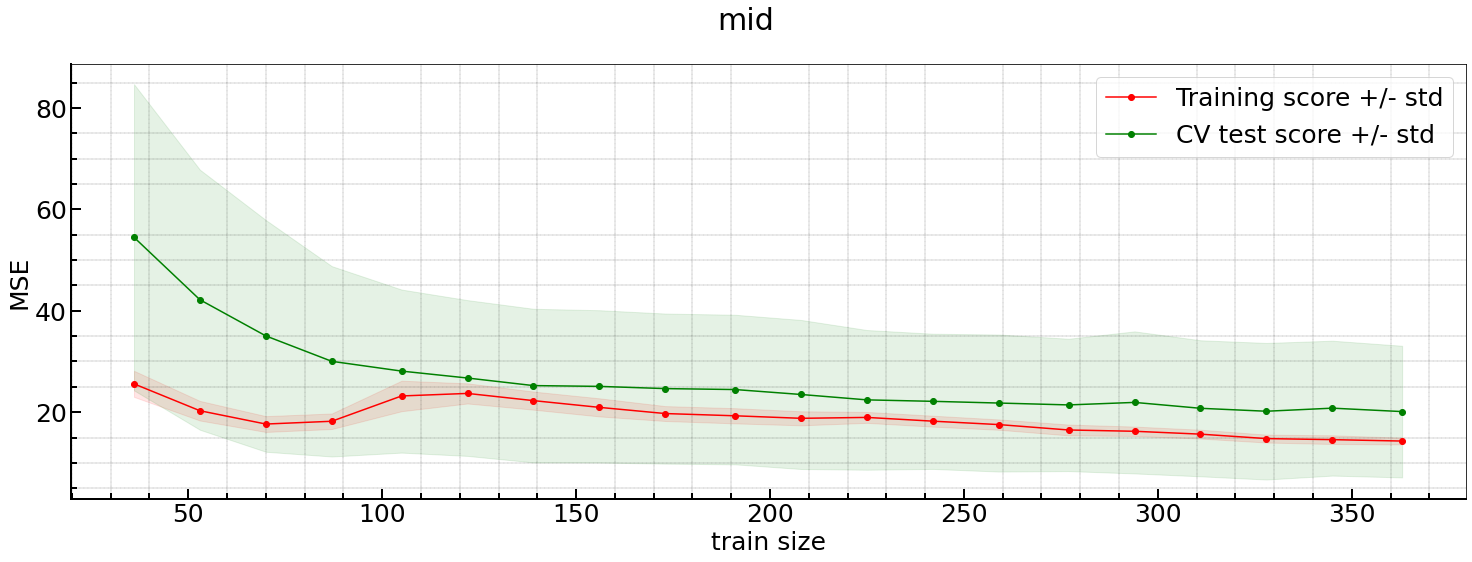

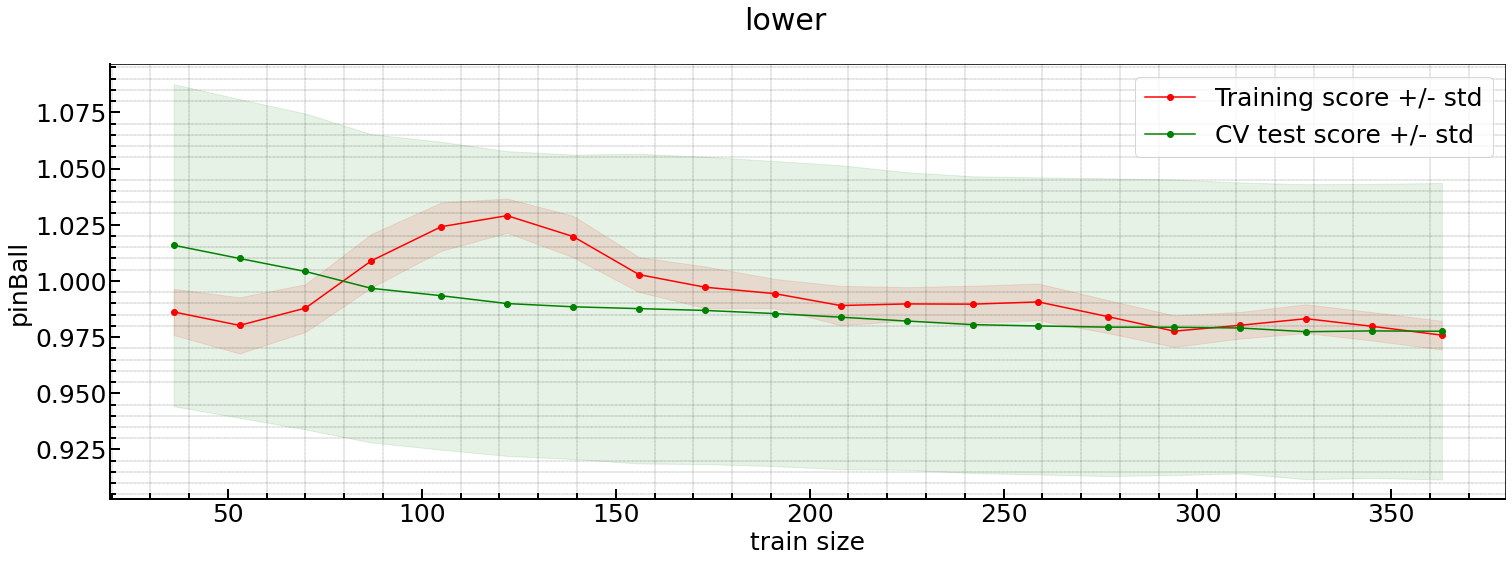

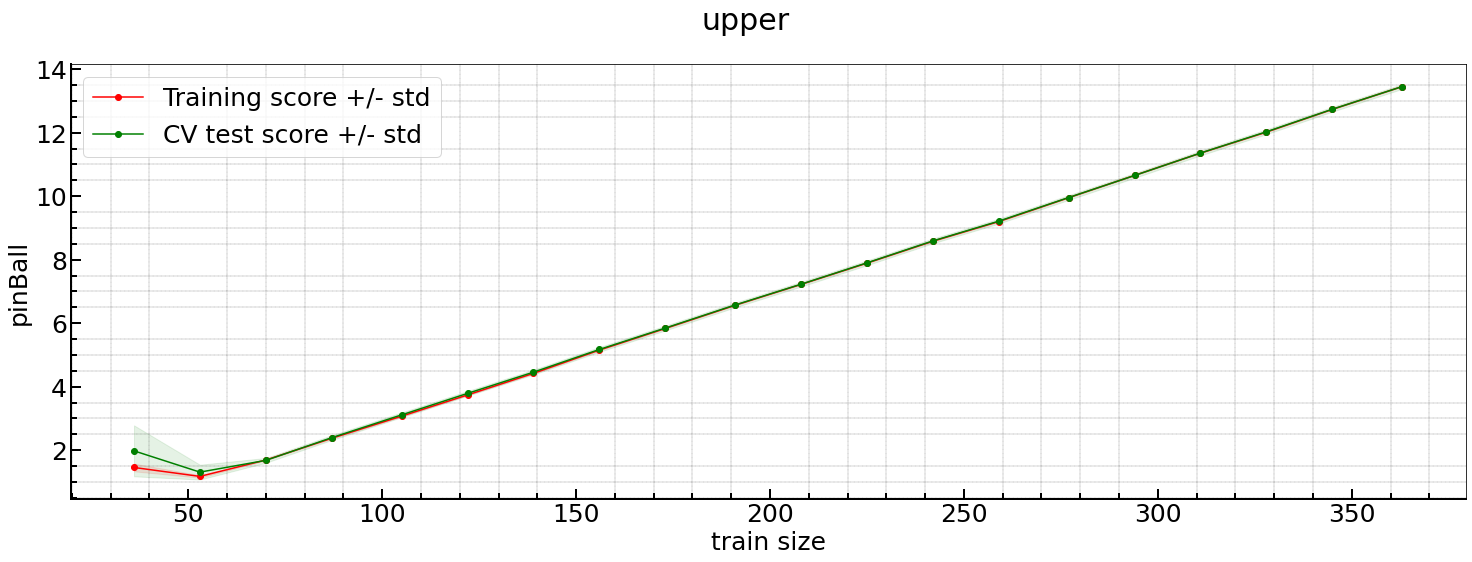

In [16]:
# I've noticed that 10-fold split is a popular setting for this small dataset
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)    


for name, model in models:
    
    score = "none"
    score_name = "pinball"
    if name == "mid":
        score = "neg_mean_squared_error"
        scoreName = "MSE"
    if name == "lower":
        score = make_scorer(mean_pinball_loss, alpha = alphaLower, greater_is_better = False)
        scoreName = "pinBall"
    if name == "upper":
        score = make_scorer(mean_pinball_loss, alpha = alphaUpper, greater_is_better = False)
        scoreName = "pinBall"
    print(score)
    #print(model)
    
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X_train, 
                                                            y_train, 
                                                            cv=kfold, 
                                                            n_jobs=-1,
                                                            train_sizes = np.linspace(0.1, 1, 20),
                                                            scoring = score)

    train_scores_mean = -1*np.mean(train_scores, axis=1)
    train_scores_std = -1*np.std(train_scores, axis=1)
    test_scores_mean = -1*np.mean(test_scores, axis=1)
    test_scores_std = -1*np.std(test_scores, axis=1)


    # Plot learning curve
    fig = plt.figure() 
    fig.suptitle(name) 
    ax = fig.add_subplot(111) 

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score +/- std")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="CV test score +/- std")
    
    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.minorticks_on()

    ax.set_xlabel("train size")
    ax.set_ylabel(scoreName)

    plt.legend(loc="best")
    plt.grid()

## Plotting learning with no-cross validation

<div class="alert alert-block alert-info">
<font color=black><br>

- **KEEP IN MIND THAT:**: since we are evaluation on two dataset because we want to see if there is a kink in the validation test set **we are not using** this flag: early_stopping_rounds = 250
- From the the figure below we can see some sign of overfitting for the lower model at around epoch No: 90.

<br></font>
</div>

In [17]:
resultsMid

{'validation_0': {'rmse': [3.921131]}, 'validation_1': {'rmse': [3.293197]}}

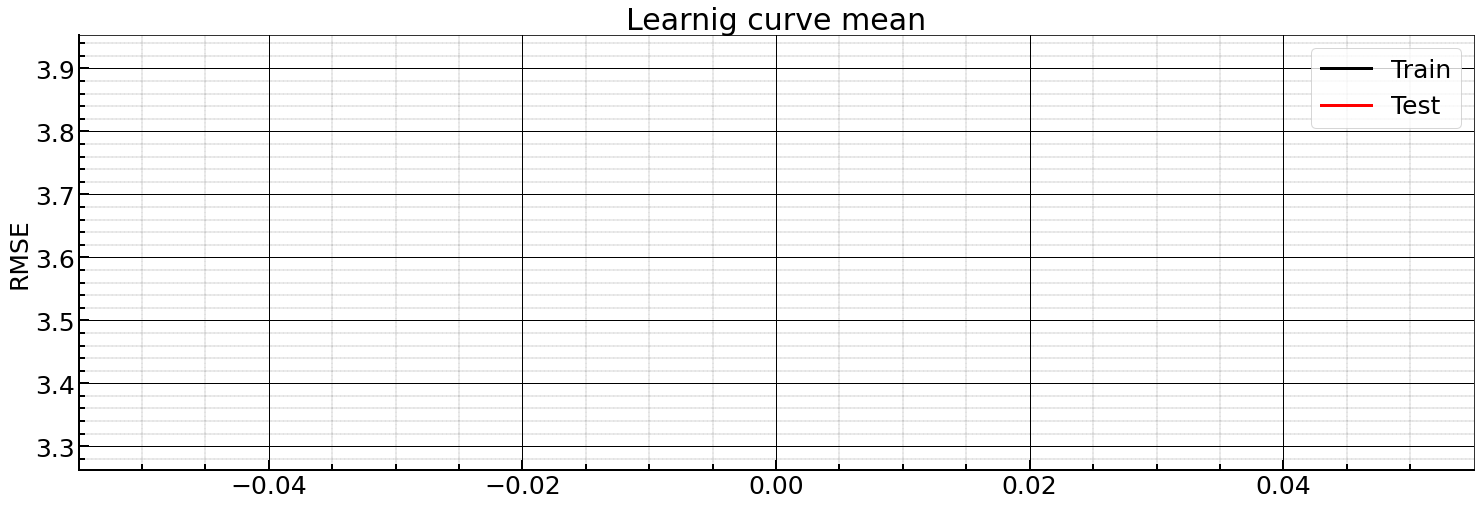

In [18]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsMid['validation_0']['rmse'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsMid['validation_0']['rmse'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsMid['validation_1']['rmse'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('Learnig curve mean')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()
    
plt.show()

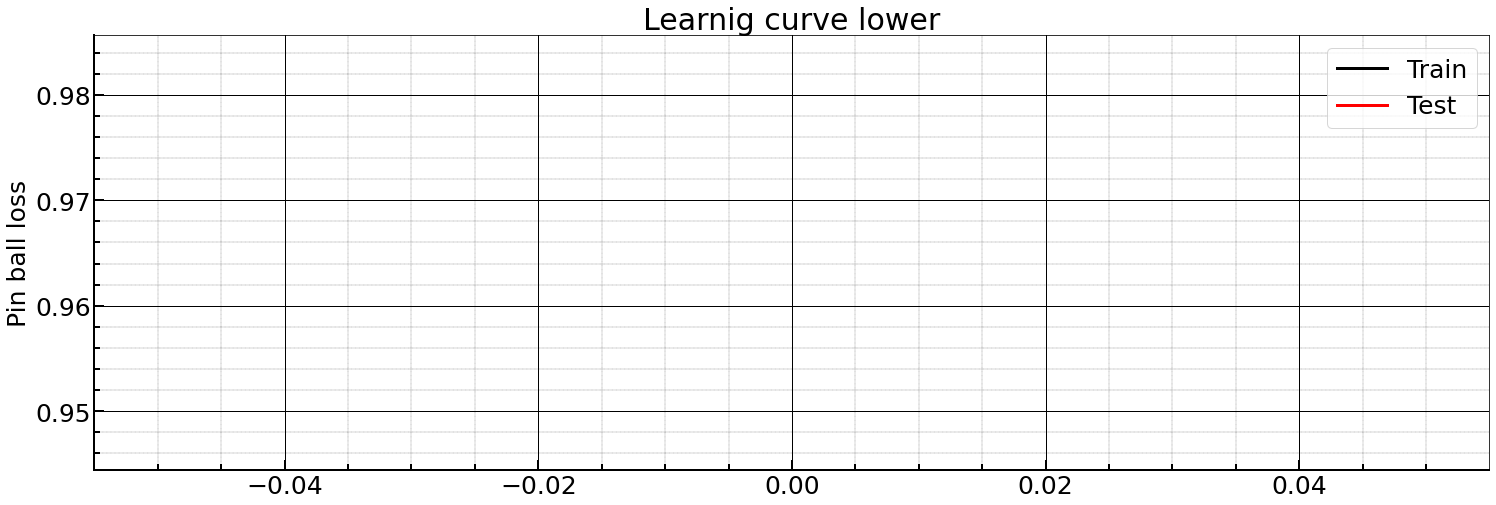

In [19]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsLow['validation_0']['PinBallLoss'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsLow['validation_0']['PinBallLoss'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsLow['validation_1']['PinBallLoss'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('Pin ball loss')
plt.title('Learnig curve lower')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.show()

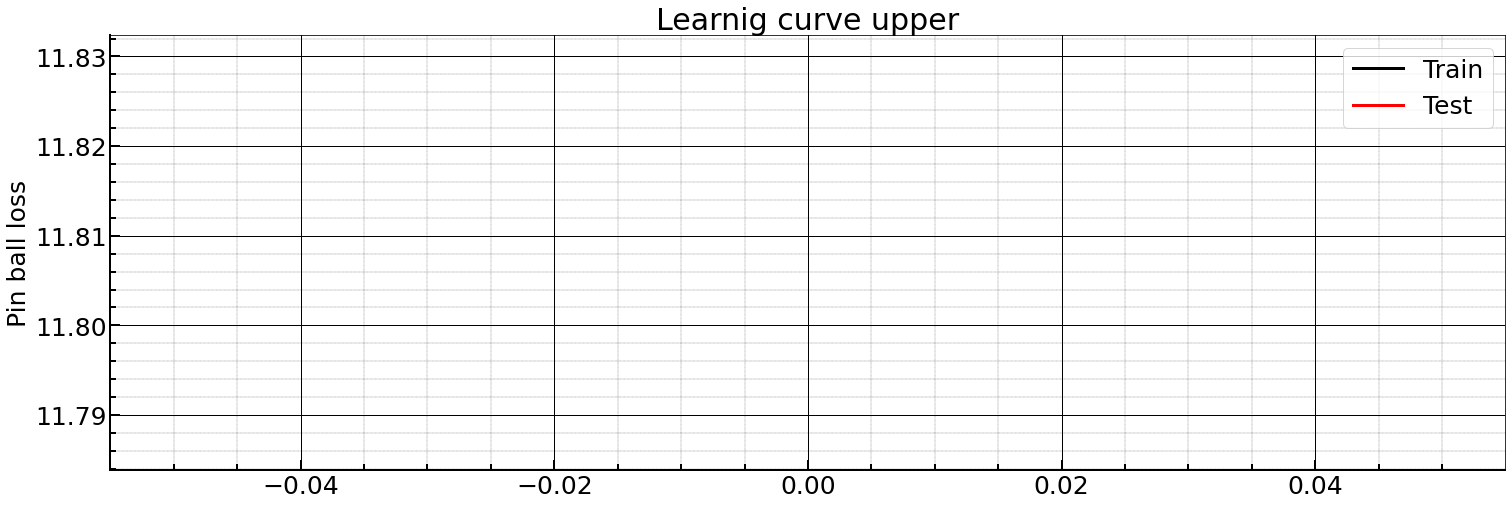

In [20]:
# plot classification error
fig, ax = plt.subplots()
epochs = len(resultsUp['validation_0']['PinBallLoss'])
x_axis = range(0, epochs)
ax.plot(x_axis, resultsUp['validation_0']['PinBallLoss'], "k-", lw = 3, label = 'Train')
ax.plot(x_axis, resultsUp['validation_1']['PinBallLoss'], "r-", lw = 3, label = 'Test')
ax.legend()
plt.ylabel('Pin ball loss')
plt.title('Learnig curve upper')

ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which = 'major', direction='in', length=10, width=2)
ax.tick_params(which = 'minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

plt.show()

# Tuning gradient boosting

<div class="alert alert-block alert-info">
<font color=black><br>

- For the mid model we'll use the **MSE** and the baseline MSE_test is ~ 12
- But for the quantile we'll have to use a different one in order to pbtain a correct calibration.
- The **pinball loss** function is a metric used to assess the accuracy of a quantile forecast. 
    
<br></font>
</div>

## Tuning for the mean -> MSE

In [21]:
param_grid = {
              "learning_rate" : [0.9, 1.0, 1.1],
              'n_estimators' : [100, 110, 120, 130],
              "num_parallel_tree": [100, 105, 106],
              "subsample": [0.5, 0.6, 0.7, 1.0],
              "colsample_bylevel": [0.5, 0.6, 0.7, 1.0],
              "colsample_bytree": [0.6, 0.8, 1.0],
              "max_depth" : [8, 9, 10, 11, 12]
             }
             

kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
rsearchMid = RandomizedSearchCV(estimator =  XGBRFRegressor(early_stopping_rounds = 10), 
                             param_distributions=param_grid, 
                             n_iter = 300, 
                             random_state=7,
                             scoring = 'neg_mean_squared_error', 
                             cv = kfold,
                             verbose = True,
                             n_jobs = -1)

rsearchMid.fit(X_train, y_train)
#print("Best hyperparamters: ", rsearch.best_estimator_)
#print("CV MSE [best hence not mean]: ", rsearch.best_score_)
#pprint(rsearch.best_params_)
indexBestModelMid = report(rsearchMid.cv_results_, n_top = 2)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
[07:06:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1
15
Model with rank: 1
Mean validation score: -19.975658893 (std: 14.150)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 100, 'n_estimators': 130, 'max_depth': 11, 'learning_rate': 1.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7}
255
Model with rank: 1
Mean validation score: -19.975658893 (std: 14.150)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 105, 'n_estimators': 130, 'max_depth': 8, 'learning_rate': 1.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7}
2


In [22]:
indexBestModelMid = report(rsearchMid.cv_results_, n_top = 1)
rsearchMid.cv_results_['params'][indexBestModelMid]

1
15
Model with rank: 1
Mean validation score: -19.975658893 (std: 14.150)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 100, 'n_estimators': 130, 'max_depth': 11, 'learning_rate': 1.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7}
255
Model with rank: 1
Mean validation score: -19.975658893 (std: 14.150)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 105, 'n_estimators': 130, 'max_depth': 8, 'learning_rate': 1.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7}


{'subsample': 1.0,
 'num_parallel_tree': 100,
 'n_estimators': 130,
 'max_depth': 11,
 'learning_rate': 1.0,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 0.7}

## Tuning for the lower and upper (quantile) -> pinball loss

In [23]:
pinballLower = make_scorer(
    mean_pinball_loss,
    alpha = alphaLower,
    greater_is_better=False)


kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
rsearchLow = RandomizedSearchCV(estimator =  XGBRFRegressor(
                                             objective=log_cosh_quantile(alphaLower),
                                             early_stopping_rounds = 10), 
                             param_distributions=param_grid, 
                             n_iter = 300, 
                             random_state=7,
                             scoring = pinballLower, 
                             cv = kfold,
                             verbose = True,
                             n_jobs = -1)


rsearchLow.fit(X_train, y_train)
print("-------------------------")
print("Quantile=" + str(alphaLower))
#print("Best hyperparamters: ", rsearch.best_estimator_)
#print("CV pinball [best hence not mean]: ", rsearch.best_score_)
report(rsearchLow.cv_results_)
indexBestModelLow = report(rsearchLow.cv_results_, n_top = 1)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
[07:06:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-------------------------
Quantile=0.04999999999999999
1
214
Model with rank: 1
Mean validation score: -0.961653816 (std: 0.066)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 106, 'n_estimators': 120, 'max_depth': 12, 'learning_rate': 1.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}
1
214
Model with rank: 1
Mean validation score: -0.961653816 (std: 0.066)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 106, 'n_estimators': 120, 'max_depth': 12, 'learning_rate': 1.1, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}


In [24]:
param_grid_special = {
              "learning_rate" : [0.0001, 0.0002, 0.00025, 0.0003],
              'n_estimators' : [150, 200, 225, 250, 260],
              "num_parallel_tree": [25, 30, 45, 50, 90, 100],
              "subsample": [0.5, 0.6, 0.7, 1.0],
              "colsample_bylevel": [0.5, 0.6, 0.7, 1.0],
              "colsample_bytree": [0.6, 0.8, 1.0],
              "max_depth" : [6, 7, 8, 9, 10, 11]
             }


pinballUpper = make_scorer(
    mean_pinball_loss,
    alpha = alphaUpper,
    greater_is_better=False)


kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)
rsearchUp = RandomizedSearchCV(estimator =  XGBRFRegressor(
                                            objective=log_cosh_quantile(alphaUpper),
                                            early_stopping_rounds = 10), 
                             param_distributions=param_grid_special, 
                             n_iter = 300, 
                             random_state=7,
                             scoring = pinballUpper, 
                             cv = kfold,
                             verbose = True,
                             n_jobs = -1)


rsearchUp.fit(X_train, y_train)
print("-------------------------")
print("Quantile=" + str(alphaLower))
#print("Best hyperparamters: ", rsearch.best_estimator_)
#print("CV pinball [best hence not mean]: ", rsearch.best_score_)
report(rsearchUp.cv_results_)
indexBestModelUp = report(rsearchUp.cv_results_, n_top = 1)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
[07:06:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-------------------------
Quantile=0.04999999999999999
1
2
Model with rank: 1
Mean validation score: -20.824725113 (std: 1.422)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 30, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0003, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6}
98
Model with rank: 1
Mean validation score: -20.824725113 (std: 1.422)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 30, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.0003, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5}
176
Model with rank: 1
Mean validation score: -20.824725113 (std: 1.422)
Parameters: {'subsample': 1.0, 'num_parallel_tree': 100, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0003, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7}
185
Model with rank: 1
Mean validatio

<ipython-input-3-6b9dfa959d80>:15: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2


## Plotting learning curves for tuned model via CV

<div class="alert alert-block alert-info">
<font color=black><br>

- Let us see how the learning curves look
- Each models will get its own hyperparameters.

<br></font>
</div>

neg_mean_squared_error
MSE


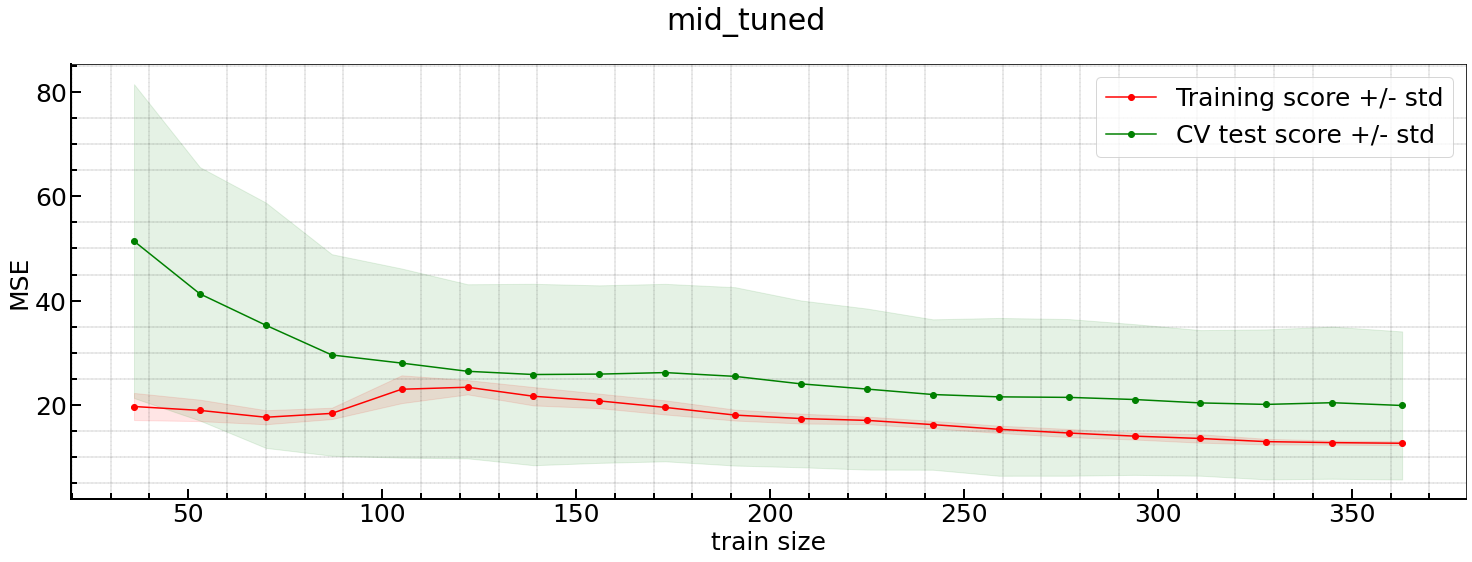

make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.04999999999999999)
pinBall


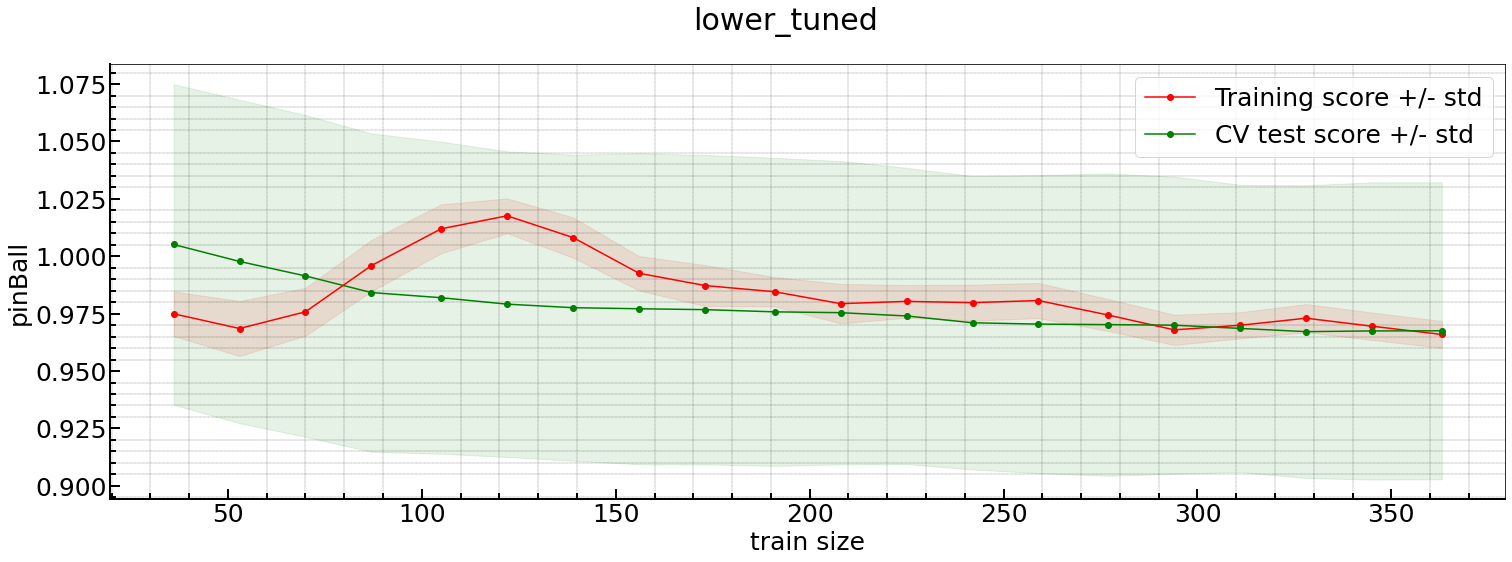

make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.95)
pinBall


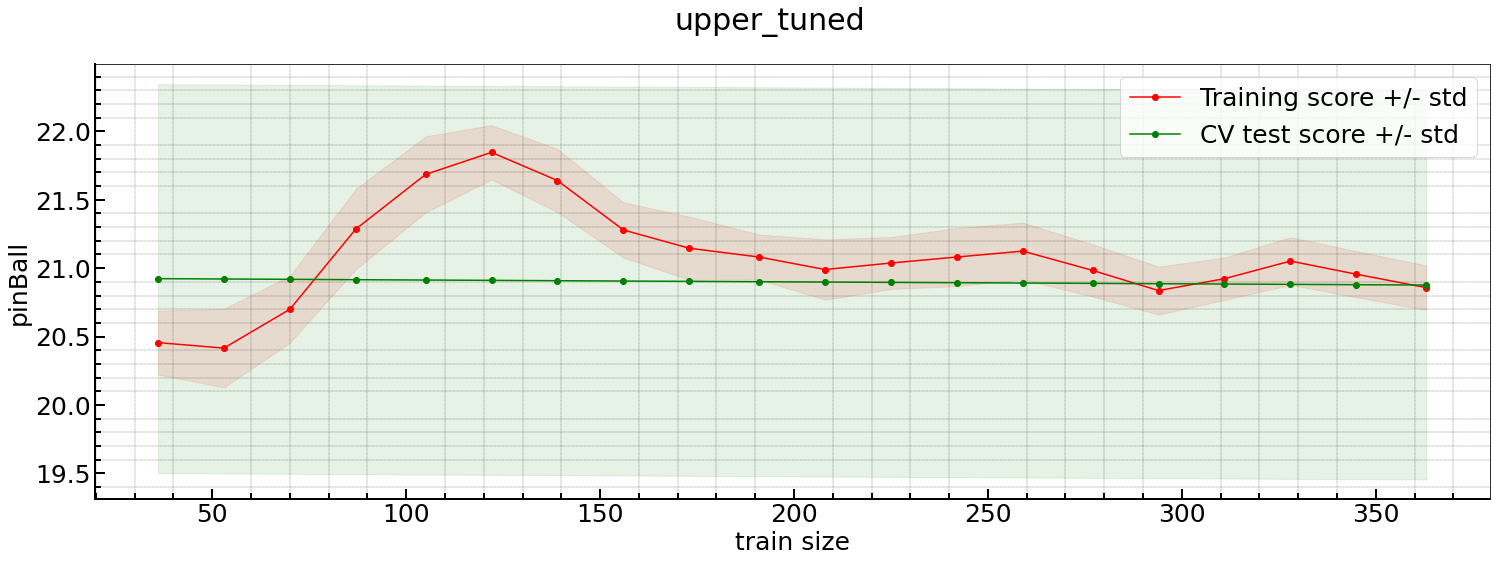

In [25]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 7)    

# As usual
mid_model_tuned = XGBRFRegressor(n_estimators = rsearchMid.cv_results_['params'][indexBestModelMid]["n_estimators"],
                               max_depth = rsearchMid.cv_results_['params'][indexBestModelMid]["max_depth"],
                               learning_rate = rsearchMid.cv_results_['params'][indexBestModelMid]["learning_rate"],                              
                               subsample = rsearchMid.cv_results_['params'][indexBestModelMid]["subsample"],
                               colsample_bytree = rsearchMid.cv_results_['params'][indexBestModelMid]["colsample_bytree"],
                               colsample_bylevel = rsearchMid.cv_results_['params'][indexBestModelMid]["colsample_bylevel"]
                               )
# Quantiles
lower_model_tuned = XGBRFRegressor(objective = log_cosh_quantile(alphaLower),
                                 n_estimators = rsearchLow.cv_results_['params'][indexBestModelLow]["n_estimators"],
                                 max_depth = rsearchLow.cv_results_['params'][indexBestModelLow]["max_depth"],
                                 learning_rate = rsearchLow.cv_results_['params'][indexBestModelLow]["learning_rate"],                              
                                 subsample = rsearchLow.cv_results_['params'][indexBestModelMid]["subsample"],
                                 colsample_bytree = rsearchLow.cv_results_['params'][indexBestModelMid]["colsample_bytree"],
                                 colsample_bylevel = rsearchLow.cv_results_['params'][indexBestModelMid]["colsample_bylevel"]
                                 )

upper_model_tuned = XGBRFRegressor(objective = log_cosh_quantile(alphaUpper),
                                 n_estimators = rsearchUp.cv_results_['params'][indexBestModelUp]["n_estimators"],
                                 max_depth = rsearchUp.cv_results_['params'][indexBestModelUp]["max_depth"],
                                 learning_rate = rsearchUp.cv_results_['params'][indexBestModelUp]["learning_rate"],                              
                                 subsample = rsearchUp.cv_results_['params'][indexBestModelMid]["subsample"],
                                 colsample_bytree = rsearchUp.cv_results_['params'][indexBestModelMid]["colsample_bytree"],
                                 colsample_bylevel = rsearchUp.cv_results_['params'][indexBestModelMid]["colsample_bylevel"]
                                  )

models = []
models.append(('mid_tuned', mid_model_tuned))
models.append(('lower_tuned', lower_model_tuned))
models.append(('upper_tuned', upper_model_tuned))


    
for name, model in models:
    score = ""
    score_name = ""
    if name == "mid_tuned":
        score = "neg_mean_squared_error"
        scoreName = "MSE"
    if name == "lower_tuned":
        score = make_scorer(mean_pinball_loss, alpha = alphaLower, greater_is_better = False)
        scoreName = "pinBall"
    if name == "upper_tuned":
        score = make_scorer(mean_pinball_loss, alpha = alphaUpper, greater_is_better = False)
        scoreName = "pinBall"
    print(score)
    print(scoreName)
    
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X_train, 
                                                            y_train, 
                                                            cv=kfold, 
                                                            n_jobs=-1,
                                                            train_sizes = np.linspace(0.1, 1, 20),
                                                            scoring = score)        
    
    train_scores_mean = -1*np.mean(train_scores, axis=1)
    train_scores_std = -1*np.std(train_scores, axis=1)
    test_scores_mean = -1*np.mean(test_scores, axis=1)
    test_scores_std = -1*np.std(test_scores, axis=1)


    # Plot learning curve
    fig = plt.figure() 
    fig.suptitle(name) 
    ax = fig.add_subplot(111) 

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score +/- std")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="CV test score +/- std")

    ax.grid(which = "major", linestyle = '-', linewidth = '1.0', color = 'k')
    ax.grid(which = "minor", linestyle = '--', linewidth = '0.25', color = 'k')
    ax.tick_params(which = 'major', direction = 'in', length = 10, width = 2)
    ax.tick_params(which = 'minor', direction = 'in', length = 6, width = 2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.minorticks_on()

    ax.set_xlabel("train size")    
    ax.set_ylabel(scoreName)

    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [26]:
lower_model_tuned.fit(X_train, y_train);
mid_model_tuned.fit(X_train, y_train);
upper_model_tuned.fit(X_train, y_train);

[07:06:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:06:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:06:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


<ipython-input-3-6b9dfa959d80>:15: RuntimeWarning: overflow encountered in square
  hess = 1 / np.cosh(err)**2


# Make predictions

<div class="alert alert-block alert-info">
<font color=black><br>

- With the models all trained, we now make predictions and record them with the true values.
- We also adding the prediction obtained tuning the model, because we wanted to verify if the lack of tuning was causing some issue.

<br></font>
</div>

In [27]:
predictions = pd.DataFrame()
predictions["ID"] = np.arange(len(X_test))
predictions['truth'] = [i[0] for i in y_test.values.tolist()]


predictions['lower_tuned'] = lower_model_tuned.predict(X_test)
predictions['lower'] = modelLow.predict(X_test)
predictions['mid_tuned'] = mid_model_tuned.predict(X_test)
predictions['mid'] = modelMid.predict(X_test)
predictions['upper_tuned'] = upper_model_tuned.predict(X_test)
predictions['upper'] = modelUp.predict(X_test)
predictions["inOrOut"] = (predictions['upper'] > predictions['mid']) & (predictions['mid'] > predictions['lower'])
predictions["inOrOut_tuned"] = (predictions['upper_tuned'] > predictions['mid_tuned']) & (predictions['mid_tuned'] > predictions['lower_tuned'])
predictions["width_tuned"] = abs(predictions['upper_tuned'] - predictions['lower_tuned'])
predictions["width"] = abs(predictions['upper'] - predictions['lower'])


In [28]:
predictions.head(5)

,ID,truth,lower_tuned,lower,mid_tuned,mid,upper_tuned,upper,inOrOut,inOrOut_tuned,width_tuned,width
0,0,21.7,2.363513,2.291851,18.607754,20.014294,0.560634,258.420197,True,False,1.802880,256.128357
1,1,18.5,2.562156,2.333353,21.249222,20.348585,0.560634,258.420197,True,False,2.001522,256.086853
2,2,22.2,2.636835,2.321846,20.696075,20.405602,0.560634,258.420197,True,False,2.076201,256.098358
3,3,20.4,2.525390,2.462211,21.889166,22.364668,0.560634,258.420197,True,False,1.964757,255.957993
4,4,8.8,1.048933,1.191834,8.839399,10.511440,0.560634,258.420197,True,False,0.488299,257.228363


<div class="alert alert-block alert-info">
<font color=black><br>

- The **first** sanity check is passed with no problem
- The **second** sanity check is not. There are some instances where the median > upper quantile.
- In the section below we'll see how the optimised model does not solve this issue.
- **However**, please look at the width of PI and the CWC metrics. These two show how the model has indeed improved.

<br></font>
</div>

In [29]:
predictions[predictions["inOrOut"] == False]

,ID,truth,lower_tuned,lower,mid_tuned,mid,upper_tuned,upper,inOrOut,inOrOut_tuned,width_tuned,width


In [30]:
predictions[predictions["inOrOut_tuned"] == False]

,ID,truth,lower_tuned,lower,mid_tuned,mid,upper_tuned,upper,inOrOut,inOrOut_tuned,width_tuned,width
0,0,21.7,2.363513,2.291851,18.607754,20.014294,0.560634,258.420197,True,False,1.802880,256.128357
1,1,18.5,2.562156,2.333353,21.249222,20.348585,0.560634,258.420197,True,False,2.001522,256.086853
2,2,22.2,2.636835,2.321846,20.696075,20.405602,0.560634,258.420197,True,False,2.076201,256.098358
3,3,20.4,2.525390,2.462211,21.889166,22.364668,0.560634,258.420197,True,False,1.964757,255.957993
4,4,8.8,1.048933,1.191834,8.839399,10.511440,0.560634,258.420197,True,False,0.488299,257.228363
...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,16.3,1.388022,1.389780,12.133183,13.758799,0.560634,258.420197,True,False,0.827389,257.030426
98,98,17.2,1.569837,1.391737,14.095669,14.463749,0.560634,258.420197,True,False,1.009203,257.028473
99,99,28.0,5.038902,4.926516,28.096119,27.523865,0.560634,258.420197,True,False,4.478269,253.493683
100,100,15.2,1.801489,1.579167,17.100027,16.524029,0.560634,258.420197,True,False,1.240856,256.841034


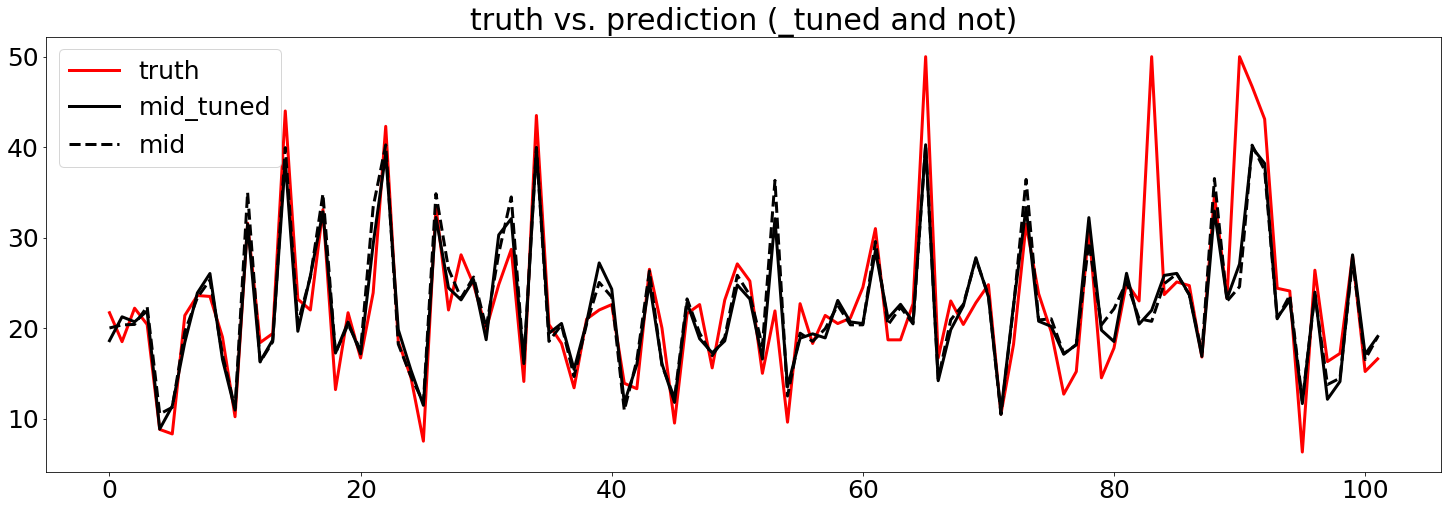

In [31]:
fig, ax = plt.subplots()

plt.title("truth vs. prediction (_tuned and not)")
dummy = range(len(predictions["mid"].values))
ax.plot(dummy, predictions["truth"].values, "-r", lw = 3, label = "truth")
ax.plot(dummy, predictions["mid_tuned"].values, "-k", lw = 3, label = "mid_tuned")
ax.plot(dummy, predictions["mid"].values, "--k", lw = 3, label = "mid")

plt.legend()
plt.show()

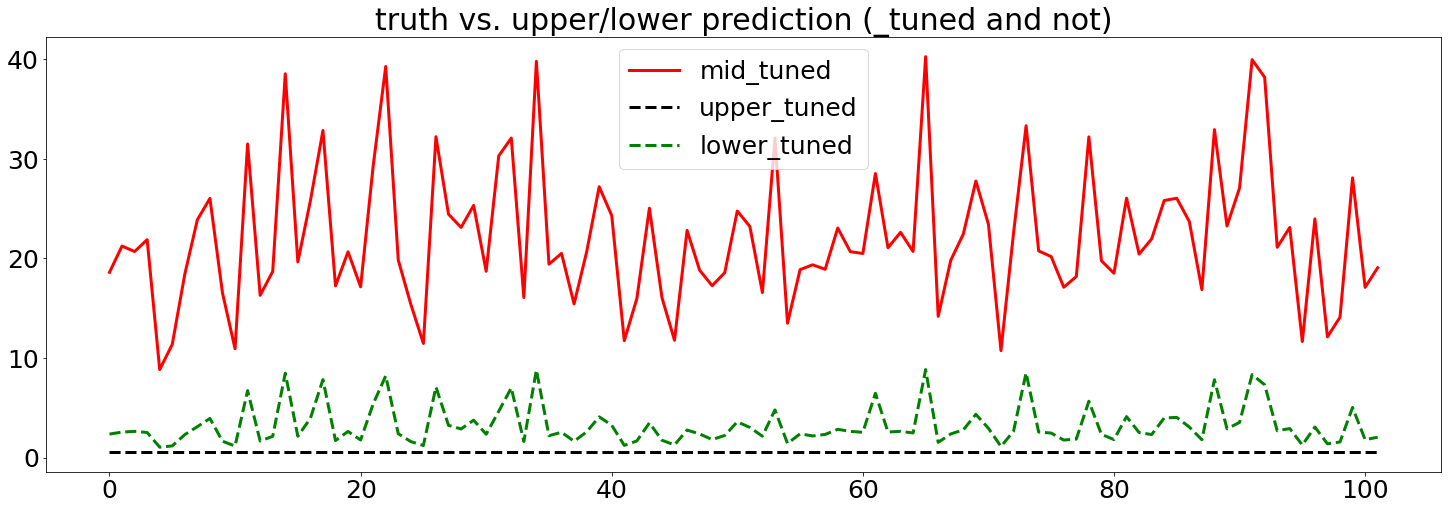

In [32]:
fig, ax = plt.subplots()

plt.title("truth vs. upper/lower prediction (_tuned and not)")
#dummy = range(len(predictions["mid_tuned"].values))
ax.plot(dummy, predictions["mid_tuned"].values, "-r", lw = 3, label = "mid_tuned")
ax.plot(dummy, predictions["upper_tuned"].values, "--k", lw = 3, label = "upper_tuned")
ax.plot(dummy, predictions["lower_tuned"].values, "--g", lw = 3, label = "lower_tuned")


plt.legend()
plt.show()

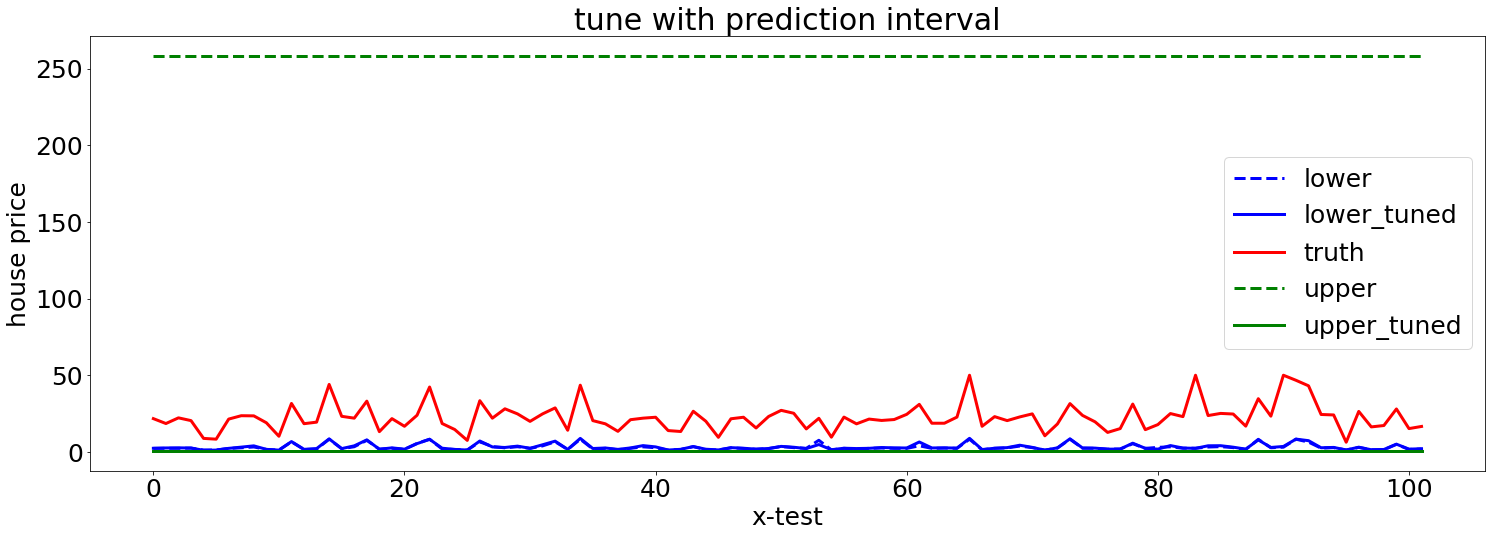

In [33]:
fig, ax = plt.subplots()

plt.title("tune with prediction interval")
ax.plot(dummy, predictions["lower"].values, "--b", lw = 3, label = "lower")
ax.plot(dummy, predictions["lower_tuned"].values, "-b", lw = 3, label = "lower_tuned")
ax.plot(dummy, predictions["truth"].values, "-r", lw = 3, label = "truth")
ax.plot(dummy, predictions["upper"].values, "--g", lw = 3, label = "upper")
ax.plot(dummy, predictions["upper_tuned"].values, "-g", lw = 3, label = "upper_tuned")

ax.set_xlabel("x-test")
ax.set_ylabel("house price")
plt.legend()
plt.show()

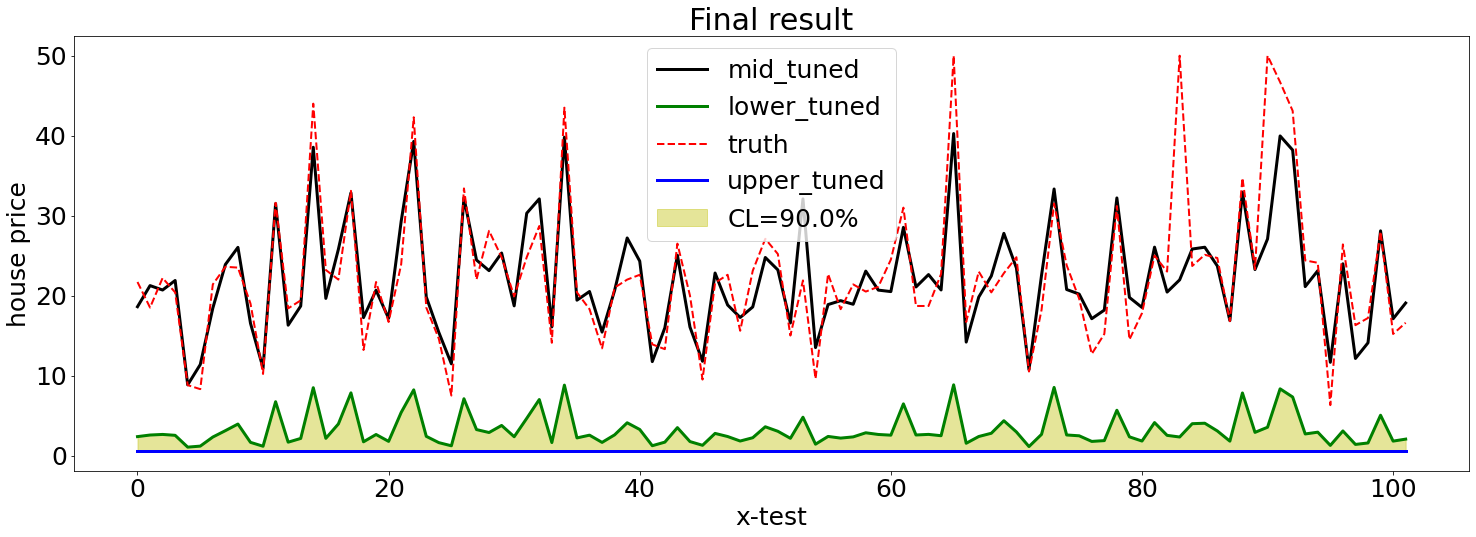

In [34]:
fig, ax = plt.subplots()

plt.title("Final result")
ax.plot(dummy, predictions["mid_tuned"].values, "-k", lw = 3, label = "mid_tuned")
ax.plot(dummy, predictions["lower_tuned"].values, "-g", lw = 3, label = "lower_tuned")
ax.plot(dummy, predictions["truth"].values, "--r", lw = 2, label = "truth")
ax.plot(dummy, predictions["upper_tuned"].values, "b-", lw = 3, label = "upper_tuned")

plt.fill_between(dummy, predictions["lower_tuned"].values, predictions["upper_tuned"].values, color = "y", alpha=0.4,
                 label='CL=' + str(CL*100)+"%")

ax.set_xlabel("x-test")
ax.set_ylabel("house price")
plt.legend()
plt.show()

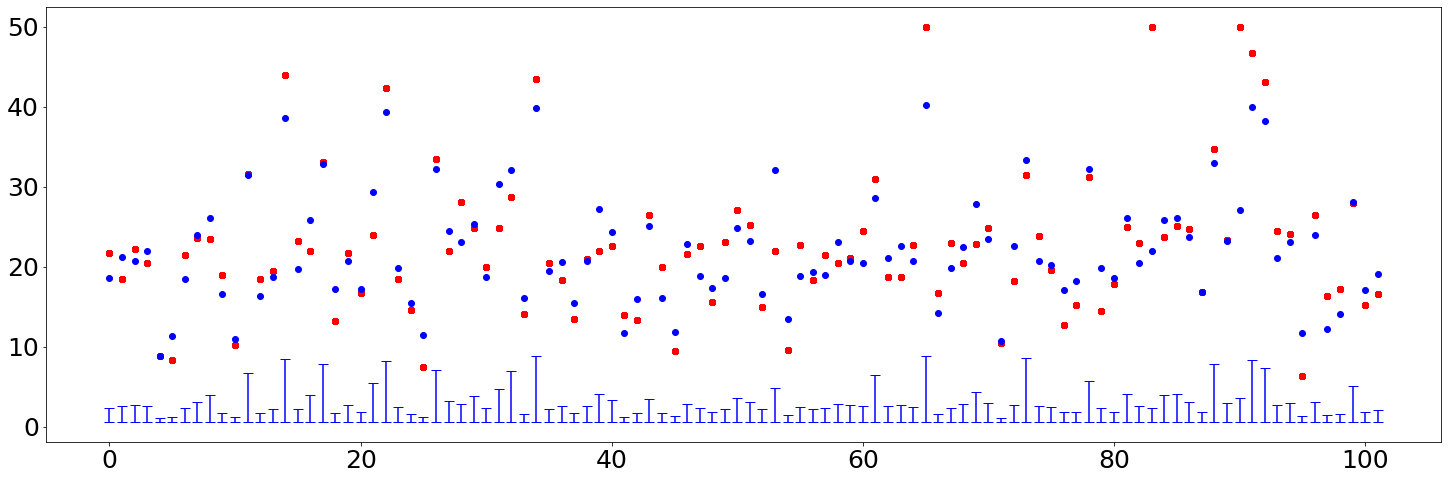

In [35]:
fig, ax = plt.subplots()

for i in range(len(predictions["ID"])):    
    ax.plot(predictions["ID"], predictions["truth"], "ro")
    mean = predictions["mid_tuned"][i]
    lower = mean - predictions["lower_tuned"][i]
    upper = predictions["upper_tuned"][i] - mean
    ax.errorbar(predictions["ID"][i], [mean], yerr=np.array([[lower, upper]]).T, fmt='bo-', 
                solid_capstyle='projecting', capsize=5)

    #ax.legend()
plt.show()

# PI coverage probability (PICP) & MPIW (Mean PI width)

<div class="alert alert-block alert-info">
<font color=black><br>

- [More important] **PI coverage probability (PICP)** is measured by counting the number of target values covered by the constructed PIs, where where ntest is the number of samples in the test set 
- [Less important] PICP has a direct relationship with the width of PIs. A satisfactorily large PICP can be easily achieved by widening PIs from either side. However, such PIs are too conservative and less useful in practice, as they do not show the variation of the targets. Therefore, a measure is required to check how wide the PIs are. **Mean PI width (MPIW)** quantifies this aspect. 
- The quality of PIs in this paper is assessed using the CWC.
- As  CWC  covers  both  key  featuresof  PIs  (width  and  coverage  probability),  it  can  be  used  as the objective function to be minimised.
- This means the **lower CWC is the better???**
- Reference about CWC: Khosravi, Abbas, et al. "Comprehensive review of neural network-based prediction intervals and new advances." IEEE Transactions on neural networks 22.9 (2011): 1341-1356.
- PIs  are  constructed  with  an  associated  90%  confidence level  (α equal  to  0.1). 
- η and μ are  set  to  50  and  0.9.

<br></font>
</div>

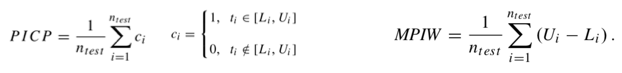

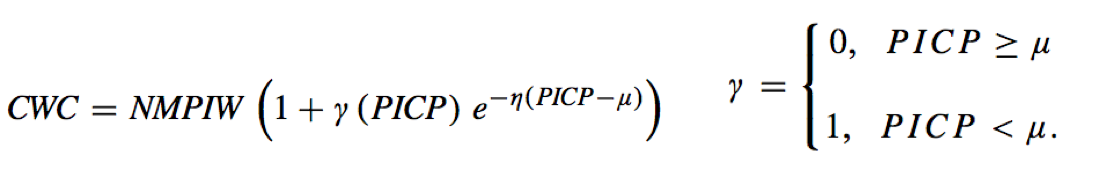

In [36]:
print("PICP      : ", len(
    predictions[predictions['inOrOut'] == True]) / len(X_test) * 100)
print("MPIW      : ", np.sum(predictions['width'].values) / len(X_test))

print("PICP_tuned: ", len(
    predictions[predictions['inOrOut_tuned'] == True]) / len(X_test) * 100)
print("MPIW_tuned: ", np.sum(predictions['width_tuned'].values) / len(X_test))

PICP      :  100.0
MPIW      :  255.37283624387254
PICP_tuned:  0.0
MPIW_tuned:  2.6730110318053004


In [37]:
nu = 0.9
eta = 50
gamma = 0
PICP = len(predictions[predictions['inOrOut'] == True]) / len(X_test)
MPIW = np.sum(predictions['width'].values) / len(X_test)
delta = predictions['width'].max() - predictions['width'].min()
NMPIW = np.sum(predictions['width'].values) / len(X_test) / delta

if PICP < nu:
    gamma = 1

CWC = NMPIW * (1 + gamma * PICP * e**(- eta * (PICP - nu)))
print("CWC_notTuned=", CWC)

CWC_notTuned= 35.87206986620605


In [38]:
nu = CL
gamma = 0
PICP = len(predictions[predictions['inOrOut_tuned'] == True]) / len(X_test)
MPIW = np.sum(predictions['width_tuned'].values) / len(X_test)
delta = predictions['width_tuned'].max() - predictions['width'].min()
NMPIW = np.sum(predictions['width_tuned'].values) / len(X_test) / delta

if PICP < nu:
    gamma = 1

CWC = NMPIW * (1 + gamma * e**(- eta * (PICP - nu)))
print("CWC_tuned=", CWC)

CWC_tuned= -3.860981936750513e+17


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed<br>
- https://nbviewer.jupyter.org/github/WillKoehrsen/Data-Analysis/blob/master/prediction-intervals/prediction_intervals.ipynb<br>
- https://scikit-learn.org/dev/auto_examples/ensemble/plot_gradient_boosting_quantile.html<br>

</font>
</div>

# Conclusion

<div class="alert alert-block alert-danger">
<font color=black><br>

- The Boston dataset is challenging because it has very little data ~500 pts.
- There are 3 models to tune: mean, upper and lowe qunatiles.
- The mean model is nothing more than the one you obtain normally.
- Each of the 3 model needs to be tuned separately and this is almost certainly going to kill oof any application for very big DL models.
- PICP & MIPW are two PI metrics for which you have to find a tradeoff.
- **CWC** and the way it was constructed does not convince me at all. Are there better formulation?

<br></font>
</div>